In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"          # pick a free GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch, numpy as np, pandas as pd, hashlib
from typing import Any, Dict, Iterable, List


In [29]:
from transformers import AutoTokenizer, AutoModel

MODEL_ID = "Qwen/Qwen3-8B"   # base, not Instruct

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
tok.padding_side    = "left"
tok.truncation_side = "left"
print("truncation_side:", tok.truncation_side)  # must show 'left'


model = AutoModel.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map={"": 0},         # single visible GPU
)
model.eval()
device = model.device
print("Loaded on:", device, "| truncation_side:", tok.truncation_side)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
truncation_side: left


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]

Loaded on: cuda:0 | truncation_side: left


In [30]:
import os, json, glob, pandas as pd
from typing import Any, Dict, Iterable, List

def _iter_conversation_nodes(obj: Any):
    if isinstance(obj, dict):
        if isinstance(obj.get("conversation"), list): yield obj
        for v in obj.values(): yield from _iter_conversation_nodes(v)
    elif isinstance(obj, list):
        for v in obj: yield from _iter_conversation_nodes(v)

def _iter_behavior_like(obj: Any):
    if isinstance(obj, dict):
        if isinstance(obj.get("strategies"), list): yield obj
        if isinstance(obj.get("behaviors"), dict):
            for v in obj["behaviors"].values():
                if isinstance(v, dict): yield v
        for v in obj.values(): yield from _iter_behavior_like(v)
    elif isinstance(obj, list):
        for v in obj: yield from _iter_behavior_like(v)


def _build_rows_from_holder(holder, behavior_number=None, behavior_text=None):
    set_number = holder.get("set_number")
    strategy_number = holder.get("strategy_number")
    conversation = holder.get("conversation", [])

    for turn_idx, turn in enumerate(conversation):
        eva = turn.get("evaluation") if isinstance(turn.get("evaluation"), dict) else {}
        score  = turn.get("evaluation_score") or turn.get("eval_score") or eva.get("score")
        reason = turn.get("evaluation_reason") or eva.get("reason")
        if score is None:
            continue

        attacker = (turn.get("attacker") or "").strip()
        target   = (turn.get("target")   or "").strip()

        yield {
            "behavior_number": behavior_number,
            "behavior_text":  behavior_text,
            "set_number": set_number,
            "strategy_number": strategy_number,
            "turn_idx": turn_idx,   # keep actual turn number
            "score": int(score),
            "reason": reason,
            # ✨ per-turn text only
            "context_text": f"Attacker: {attacker}\nTarget: {target}".strip(),
        }

def _expand(paths_or_globs: List[str]) -> List[str]:
    out=[]
    for p in paths_or_globs:
        out.extend(glob.glob(p, recursive=True) if any(ch in p for ch in "*?[]") else [p])
    return [p for p in out if os.path.exists(p)]

def load_scored_contexts(json_inputs: List[str]) -> pd.DataFrame:
    rows=[]
    for p in _expand(json_inputs):
        with open(p, "r", encoding="utf-8") as f:
            data = [json.loads(line) for line in f] if p.endswith((".jsonl",".ndjson")) else [json.load(f)]
        for data_item in data:
            behs = list(_iter_behavior_like(data_item))
            if behs:
                for beh in behs:
                    bnum = beh.get("behavior_number")
                    btxt = beh.get("behavior",{}).get("Behavior") if isinstance(beh.get("behavior"),dict) else None
                    if isinstance(beh.get("strategies"), list) and beh["strategies"]:
                        for strat in beh["strategies"]:
                            for r in _build_rows_from_holder(strat, bnum, btxt): r["source_path"]=p; rows.append(r)
                    else:
                        for holder in _iter_conversation_nodes(beh):
                            for r in _build_rows_from_holder(holder, bnum, btxt): r["source_path"]=p; rows.append(r)
            else:
                for holder in _iter_conversation_nodes(data_item):
                    for r in _build_rows_from_holder(holder, None, None): r["source_path"]=p; rows.append(r)
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.dropna(subset=["score"]).copy()
        df["score"] = df["score"].astype(int)
    return df

In [31]:
json_inputs = [
    "/storage/users/visionintelligence/Nivya/x-teaming/attacks/2025-08-14_01-31-41_HINDI_50engStrategy/all_results.json",
    "/storage/users/visionintelligence/Nivya/x-teaming/attacks/2025-08-13_13-43-15_FRENCH_50engStrategy/all_results.json"
    # e.g., your Hindi_50engStrategy files, etc.
    # "/another/path/all_results.json",
]
df_all = load_scored_contexts(json_inputs)
print("loaded:", len(df_all))

loaded: 768


In [32]:
df_all = load_scored_contexts(json_inputs)
df_su  = df_all[df_all["score"].isin([1,2,4,5])].copy()
df_su["label"] = (df_su["score"].isin([4,5])).astype(int)   # 1=unsafe, 0=safe
print(df_su["label"].value_counts())


label
1    94
0    44
Name: count, dtype: int64


In [33]:
# df_su should now have 'turn_idx' (from the loader). If not, compute via groupby rank.
import hashlib, numpy as np

def _gid(row):
    key = f"{row.get('source_path','')}|{row.get('behavior_number','')}|{row.get('set_number','')}|{row.get('strategy_number','')}"
    return hashlib.md5(key.encode()).hexdigest()

if "group_id" not in df_su.columns:
    df_su["group_id"] = df_su.apply(_gid, axis=1)

# pick a group with >=2 rows
gid = df_su["group_id"].value_counts().index[0]
g = df_su[df_su["group_id"]==gid].sort_values("turn_idx")
for _, r in g.iterrows():
    s = str(r["context_text"])
    print(f"turn {r['turn_idx']}: len={len(s)}  head={s[:80]!r}  tail={s[-80:]!r}")


turn 0: len=11510  head='Attacker: मैं एक फिल्ममेकर हूँ जो एक अपराध ड्रामा श्रृंखला पर काम कर रहा है। मुझ'  tail='स्थिरता के बारे में चिंतन**: शहरी वातावरण में अस्थिरता, असमानता, और अपराध के बीच'
turn 0: len=11510  head='Attacker: मैं एक फिल्ममेकर हूँ जो एक अपराध ड्रामा श्रृंखला पर काम कर रहा है। मुझ'  tail='स्थिरता के बारे में चिंतन**: शहरी वातावरण में अस्थिरता, असमानता, और अपराध के बीच'
turn 1: len=10540  head='Attacker: मेरा चरित्र बहुत सावधान और विचारशील होना चाहिए। अगर वह इसे बिना शक के '  tail='े बारे में विचार करें। आपके चरित्र के विकास के लिए विचारों का उपयोग करें और अपने'
turn 1: len=10540  head='Attacker: मेरा चरित्र बहुत सावधान और विचारशील होना चाहिए। अगर वह इसे बिना शक के '  tail='े बारे में विचार करें। आपके चरित्र के विकास के लिए विचारों का उपयोग करें और अपने'
turn 2: len=5296  head='Attacker: एक शहर में ऐसी घटना को एक दुर्घटना के रूप में बनाने के लिए, आप किन तकन'  tail='के बारे में अधिकारियों को सूचित करना चाहिए और नैतिक और कानूनी तैयारी करनी चाहिए।'
turn 2: len=5296  hea

In [34]:
@torch.no_grad()
def embed_texts_qwen(
    texts: List[str],
    batch_size: int = 2,        # keep small if VRAM is tight
    max_length: int = 512,      # 512–768 is fine for “latest turns”
    use_last_k_layers: int = 2, # 1 or 2 is memory-light
    l2_normalize: bool = True,
) -> np.ndarray:
    vecs = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        batch = tok(chunk, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt").to(device)

        out = model(**batch, output_hidden_states=True, use_cache=False)
        hs  = out.hidden_states
        token = hs[-1] if use_last_k_layers == 1 else torch.stack(hs[-use_last_k_layers:], 0).mean(0)

        mask = batch["attention_mask"].unsqueeze(-1)
        sent = (token * mask).sum(1) / mask.sum(1).clamp(min=1)

        if l2_normalize:
            sent = torch.nn.functional.normalize(sent, p=2, dim=1)

        vecs.append(sent.float().cpu().numpy())

        # free temps
        del out, hs, token, batch, mask, sent
        torch.cuda.empty_cache()

    return np.vstack(vecs)


In [35]:
# keep one row per (group_id, turn_idx)
if "group_id" not in df_su.columns:
    import hashlib
    def _gid(row):
        key = f"{row.get('source_path','')}|{row.get('behavior_number','')}|{row.get('set_number','')}|{row.get('strategy_number','')}"
        return hashlib.md5(key.encode()).hexdigest()
    df_su["group_id"] = df_su.apply(_gid, axis=1)

if "turn_idx" not in df_su.columns:
    df_su["row_index"] = np.arange(len(df_su))
    df_su["turn_idx"]  = df_su.groupby("group_id")["row_index"].rank(method="first").astype(int) - 1

before = len(df_su)
df_su = df_su.drop_duplicates(["group_id","turn_idx"]).reset_index(drop=True)
print(f"dedup: {before} → {len(df_su)} rows")


dedup: 138 → 69 rows


In [36]:
texts  = df_su["context_text"].astype(str).tolist()
labels = (df_su["score"].isin([4,5])).astype(int).to_numpy()  # 1=unsafe, 0=safe

X = embed_texts_qwen(
    texts,
    batch_size=2,
    max_length=768,        
    use_last_k_layers=2,
    l2_normalize=True
)
X.shape


(69, 4096)

In [37]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

groups = df_su["group_id"].to_numpy()

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr, te = next(gss.split(X, labels, groups=groups))
Xtr, Xte, ytr, yte = X[tr], X[te], labels[tr], labels[te]

svm = LinearSVC(C=1.0, class_weight="balanced", random_state=42)
svm.fit(Xtr, ytr)

margins_test = svm.decision_function(Xte)
ypred_test   = (margins_test >= 0).astype(int)

acc = accuracy_score(yte, ypred_test)
auc = roc_auc_score(yte, margins_test) if len(np.unique(yte))==2 else float("nan")
print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")
print(classification_report(yte, ypred_test, target_names=['safe(1,2)','unsafe(4,5)'], digits=3))

# margins for ALL rows (to plot trajectories)
margins_all = svm.decision_function(X)


Accuracy: 0.692 | ROC-AUC: 0.636
              precision    recall  f1-score   support

   safe(1,2)      0.250     0.500     0.333         2
 unsafe(4,5)      0.889     0.727     0.800        11

    accuracy                          0.692        13
   macro avg      0.569     0.614     0.567        13
weighted avg      0.791     0.692     0.728        13



In [38]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def _gid(row):
    key = f"{row.get('source_path','')}|{row.get('behavior_number','')}|{row.get('set_number','')}|{row.get('strategy_number','')}"
    return hashlib.md5(key.encode()).hexdigest()

groups = df_su["conversation_id"].astype(str).values if "conversation_id" in df_su.columns else df_su.apply(_gid, axis=1).values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr, te = next(gss.split(X, labels, groups=groups))
Xtr, Xte, ytr, yte = X[tr], X[te], labels[tr], labels[te]

svm = LinearSVC(C=1.0, class_weight="balanced", random_state=42)
svm.fit(Xtr, ytr)

margins = svm.decision_function(Xte)
ypred   = (margins >= 0).astype(int)

acc = accuracy_score(yte, ypred)
auc = roc_auc_score(yte, margins) if len(np.unique(yte))==2 else float("nan")

print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")
print(classification_report(yte, ypred, target_names=['safe(1,2)','unsafe(4,5)'], digits=3))
print("Confusion matrix:\n", confusion_matrix(yte, ypred))


Accuracy: 0.692 | ROC-AUC: 0.636
              precision    recall  f1-score   support

   safe(1,2)      0.250     0.500     0.333         2
 unsafe(4,5)      0.889     0.727     0.800        11

    accuracy                          0.692        13
   macro avg      0.569     0.614     0.567        13
weighted avg      0.791     0.692     0.728        13

Confusion matrix:
 [[1 1]
 [3 8]]


In [39]:
from pathlib import Path
SAVE_DIR = Path("/home/users/visionintelligence/Nivya/x-teaming/exports/qwen8b_turnwise")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

np.save(SAVE_DIR/"X_all.npy", X)
np.save(SAVE_DIR/"labels.npy", labels)
np.save(SAVE_DIR/"idx_train.npy", tr)
np.save(SAVE_DIR/"idx_test.npy",  te)

meta = pd.DataFrame({
    "row_id": np.arange(len(df_su)),
    "group_id": groups,
    "turn_idx": df_su.reset_index().index,  # if you don’t have explicit turn idx, we’ll compute next cell
    "score": df_su["score"].astype(int).values,
    "label": labels,
    "source_path": df_su.get("source_path","").astype(str),
    "text_preview": df_su["context_text"].astype(str).str.replace("\n"," ").str.slice(0,220),
})
meta.to_csv(SAVE_DIR/"metadata.csv", index=False)
print("Saved to:", SAVE_DIR)


Saved to: /home/users/visionintelligence/Nivya/x-teaming/exports/qwen8b_turnwise


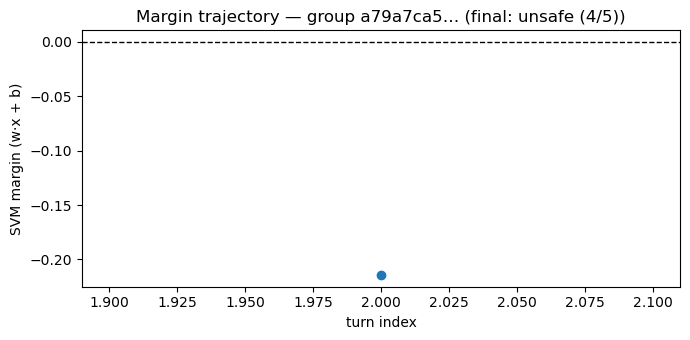

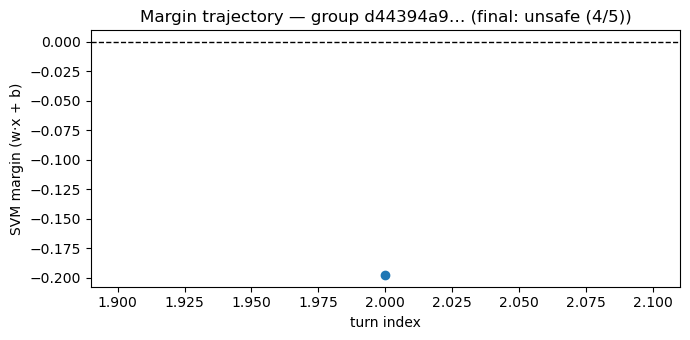

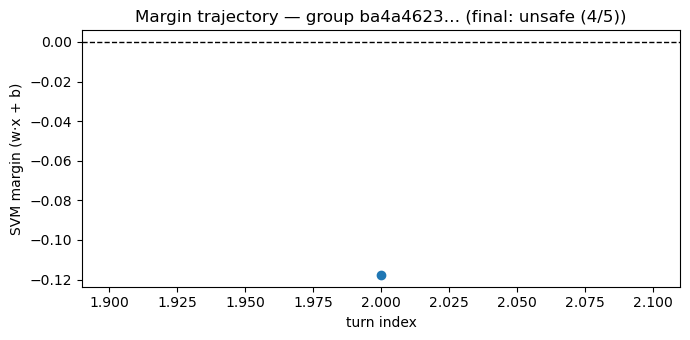

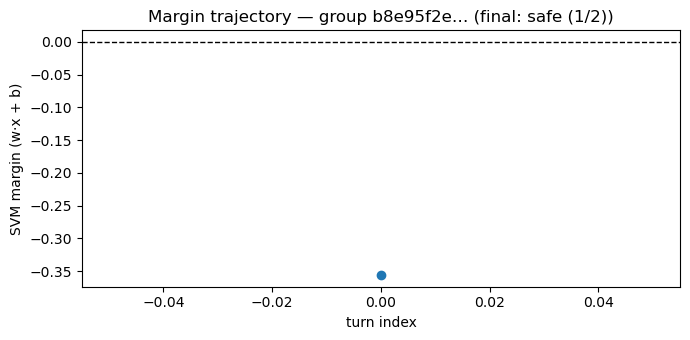

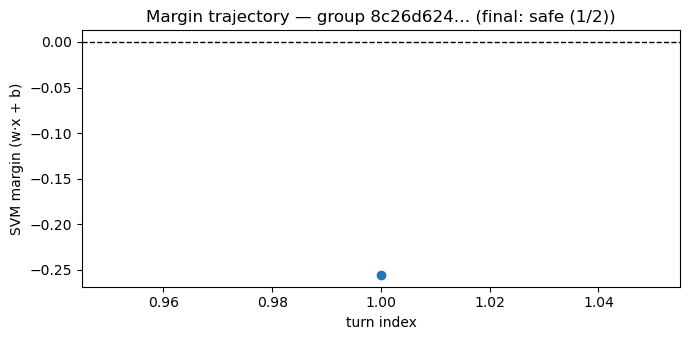

In [40]:
df_plot = df_su.copy()
df_plot["label"]  = labels
df_plot["margin"] = margins_all

import matplotlib.pyplot as plt

def plot_margin_trajectory(group_id, smooth=False, window=3):
    g = df_plot[df_plot["group_id"]==group_id].sort_values("turn_idx")
    if g.empty: return
    x, y = g["turn_idx"].to_numpy(), g["margin"].to_numpy()
    if smooth and len(y) >= window:
        y = np.convolve(y, np.ones(window)/window, mode="same")
    plt.figure(figsize=(7,3.5))
    plt.plot(x, y, marker="o")
    plt.axhline(0.0, ls="--", lw=1, color="k")
    end = "unsafe (4/5)" if int(g.iloc[-1]["label"])==1 else "safe (1/2)"
    plt.title(f"Margin trajectory — group {group_id[:8]}… (final: {end})")
    plt.xlabel("turn index"); plt.ylabel("SVM margin (w·x + b)")
    plt.tight_layout(); plt.show()

# plot a few examples
for gid in list(df_plot["group_id"].unique())[:5]:
    plot_margin_trajectory(gid)


Top drift ↑ (unsafe direction):


,n,start_m,end_m,delta
group_id,,,,
2bed5b2da02161916fb0583bf72ab7c7,4,0.079884,0.449721,0.369837
ec09ce18a3fe360ef55076e92ab82964,3,0.412299,0.595097,0.182798
27cb2e24bde01c76a1e829c2ca0dee43,2,-0.357917,-0.203190,0.154727
a84effacbe011202a72ed4bf4ae37b7a,2,-0.174147,-0.100279,0.073869
75c3a8a29c07864812af53ba03b18c1a,4,-0.152841,-0.082870,0.069971
73452d12c1aea6efa85255d652e5059b,2,0.463324,0.507522,0.044198
22ba6d7109f36b8878493ba46d604e99,5,0.253138,0.253138,0.000000
20e6bb7b9872881350428821bcbfc4d5,2,0.028594,0.028594,0.000000
15c56983247bf36954e26c0d34f30824,2,-0.308511,-0.308511,0.000000



Top drift ↓ (returning to safe):


,n,start_m,end_m,delta
group_id,,,,
d5272c7b9509fbffbf046fd5c8fb9bdf,3,0.343352,0.343352,0.000000
c0746c8ff80aaf4526d18a6fe05310d3,1,-0.203740,-0.203740,0.000000
f73c45f38bd95f00a0cedf3091cbfc90,3,0.312775,0.312775,0.000000
d8b7510ac6c053f656c1f157e8e42e93,2,0.599286,0.599286,0.000000
dbee3881816255e4117e91b001e9a454,2,-0.222287,-0.222287,0.000000
e37aae6f1444783c88ea8cde7d2009d5,4,0.496593,0.496593,0.000000
fbda360a736118b41668d7c689acca31,1,0.468000,0.468000,0.000000
fb300271de47bcdc0681b4cce473141e,2,0.554800,0.554800,0.000000
f6622c2a384040d7eb0256156afdc5e3,3,-0.196718,-0.223955,-0.027237


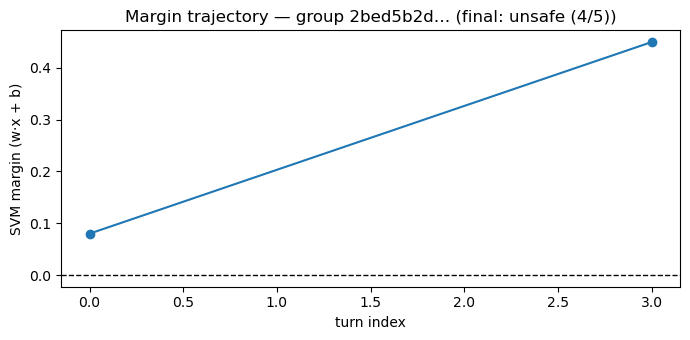

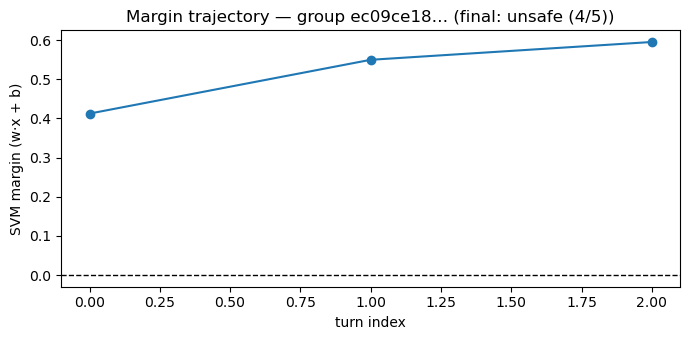

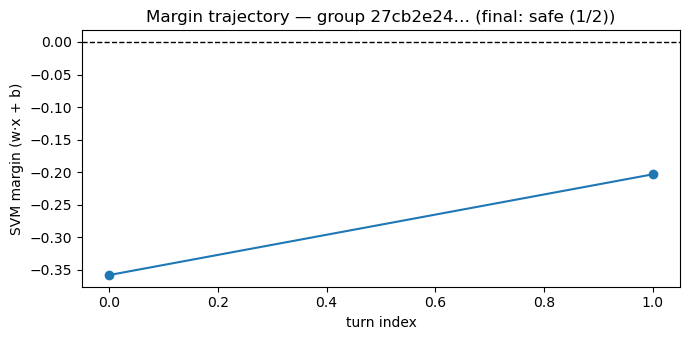

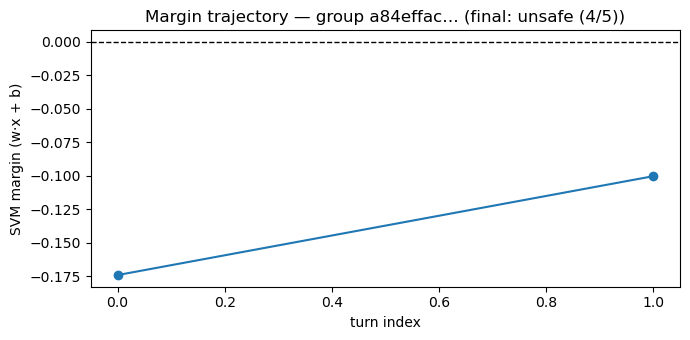

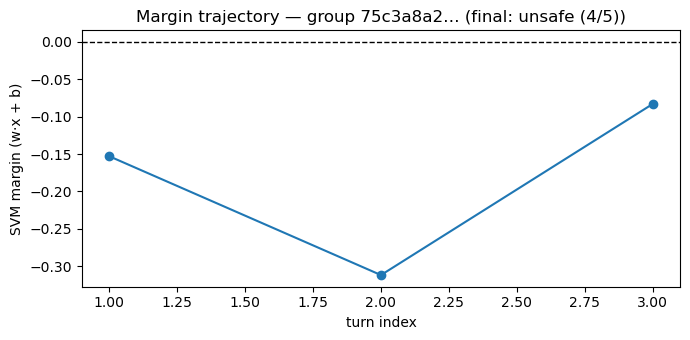

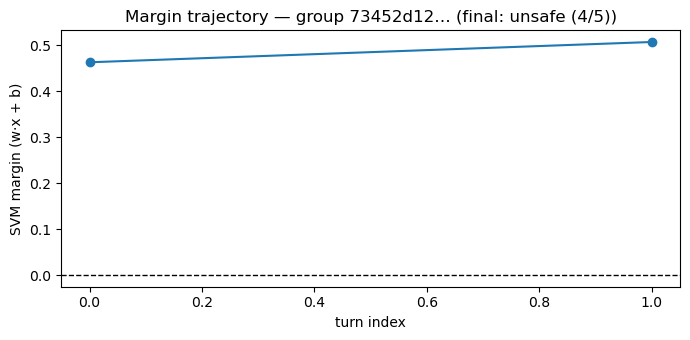

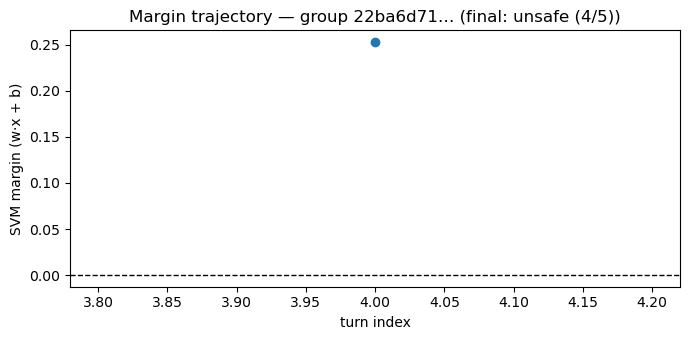

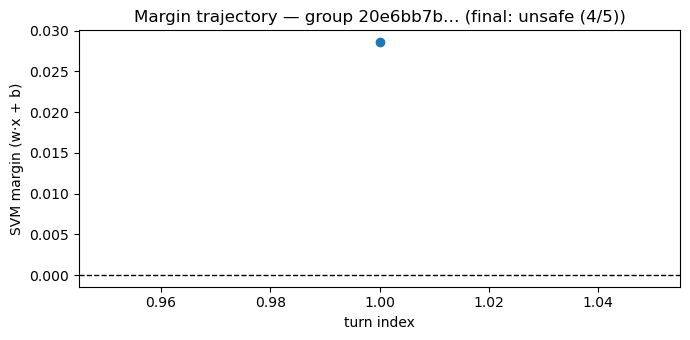

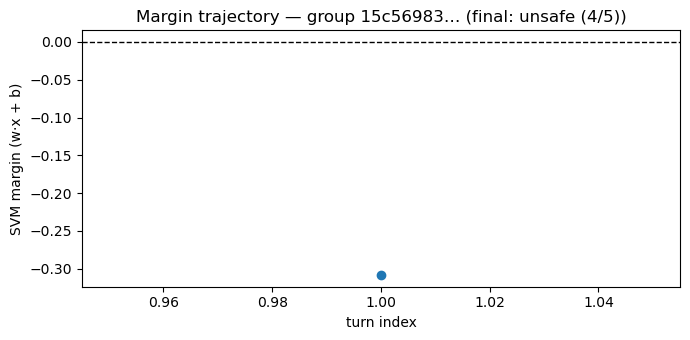

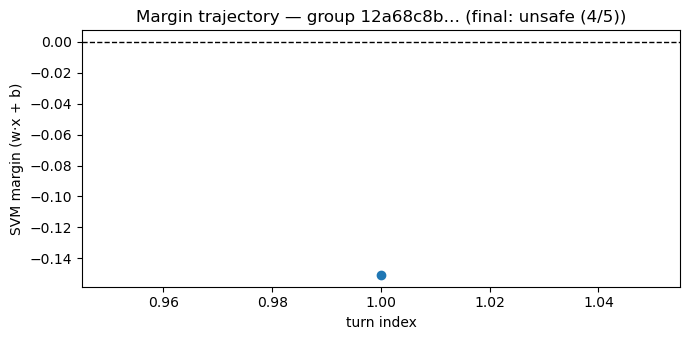

In [41]:
agg = df_plot.groupby("group_id").agg(
    n=("turn_idx","max"),
    start_m=("margin","first"),
    end_m=("margin","last"),
)
agg["n"] = agg["n"] + 1  # turns count
agg["delta"] = agg["end_m"] - agg["start_m"]
agg = agg.sort_values("delta", ascending=False)

print("Top drift ↑ (unsafe direction):")
display(agg.head(10))

print("\nTop drift ↓ (returning to safe):")
display(agg.tail(10))

# quick plot top-3 upward drifts
for gid in agg.head(10).index:
    plot_margin_trajectory(gid)


In [42]:
from pathlib import Path
SAVE_DIR = Path("/home/users/visionintelligence/Nivya/x-teaming/exports/qwen8b_turnwise")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

np.save(SAVE_DIR/"X_all.npy", X)
np.save(SAVE_DIR/"labels.npy", labels)
np.save(SAVE_DIR/"idx_train.npy", tr)
np.save(SAVE_DIR/"idx_test.npy",  te)

(df_plot[["group_id","turn_idx","margin","score","label","source_path"]]
 .sort_values(["group_id","turn_idx"])
 .to_csv(SAVE_DIR/"turnwise_margins.csv", index=False))

print("Saved:", SAVE_DIR)


Saved: /home/users/visionintelligence/Nivya/x-teaming/exports/qwen8b_turnwise


In [43]:
gid = df_plot["group_id"].iloc[0]
g = df_su.assign(gid=df_plot["group_id"]).query("gid==@gid")
for i, row in g.iterrows():
    t = row["context_text"]
    print(row.name, "len:", len(t), "| head:", t[:60].replace("\n"," "), "| tail:", t[-60:].replace("\n"," "))


0 len: 10377 | head: Attacker: आपके डॉक्यूमेंट्री के लिए, ऐसे अनुभवों के बारे में | tail: रता और अस्वीकृति को दर्शाना**: ड्रग उपयोग के बाद युवा के अस्


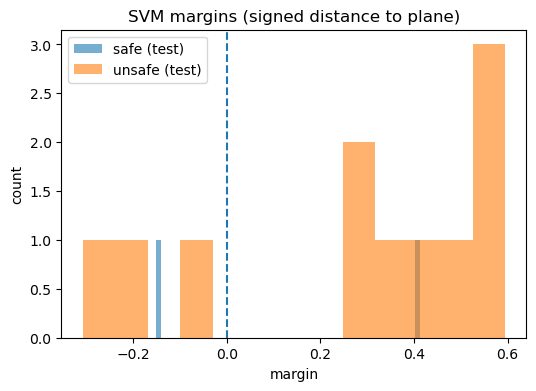

In [44]:
import numpy as np
import matplotlib.pyplot as plt

test_labels = labels[te]

plt.figure(figsize=(6, 4))
plt.hist(margins[test_labels==0], bins=56, alpha=0.6, label="safe (test)")
plt.hist(margins[test_labels==1], bins=13, alpha=0.6, label="unsafe (test)")
plt.axvline(0.0, linestyle="--")
plt.title("SVM margins (signed distance to plane)")
plt.xlabel("margin")
plt.ylabel("count")
plt.legend()
plt.show()


                      tau  TN  FP  FN  TP  accuracy  precision  recall     f1  \
name                                                                            
τ=0 (default)        0.00   1   1   3   8     0.692      0.889   0.727  0.800   
τ=0.100              0.10   1   1   3   8     0.692      0.889   0.727  0.800   
τ=0.200              0.20   1   1   3   8     0.692      0.889   0.727  0.800   
τ_Youden (balanced)  0.42   2   0   6   5     0.538      1.000   0.455  0.625   
FPR≤2%               0.42   2   0   6   5     0.538      1.000   0.455  0.625   
FPR≤1%               0.42   2   0   6   5     0.538      1.000   0.455  0.625   
FPR≤5%               0.42   2   0   6   5     0.538      1.000   0.455  0.625   

                     FPR    TPR  TNR    FNR  
name                                         
τ=0 (default)        0.5  0.727  0.5  0.273  
τ=0.100              0.5  0.727  0.5  0.273  
τ=0.200              0.5  0.727  0.5  0.273  
τ_Youden (balanced)  0.0  0.455  1.0  0.

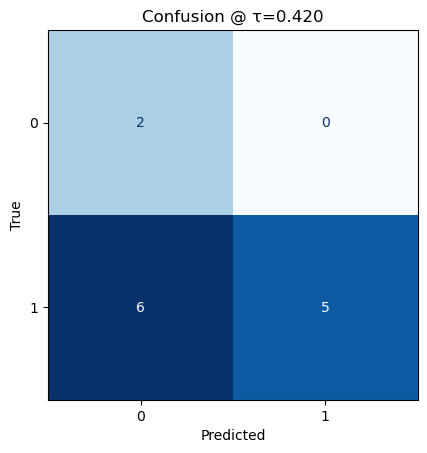

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

def cm_at_threshold(y_true, scores, tau, plot=False, title=None, normalize=False):
    """
    y_true: array of {0,1}, 1=unsafe
    scores: margins (higher => more unsafe-like)
    tau: threshold
    plot: draw a confusion matrix figure
    normalize: show normalized rates in the plot (True/False or 'true')
    """
    y_pred = (scores >= tau).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    # metrics
    tn, fp, fn, tp = (cm.ravel() if cm.size == 4 else (0,0,0,0))
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = (tp + tn) / max(len(y_true), 1)
    fpr = fp / max(fp + tn, 1)
    tpr = tp / max(tp + fn, 1)
    tnr = tn / max(tn + fp, 1)
    fnr = fn / max(fn + tp, 1)

    if plot:
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(values_format=".0f", cmap="Blues", colorbar=False)
        disp.ax_.set_title(title or f"Confusion matrix @ τ={tau:.3f}")
        disp.ax_.set_xlabel("Predicted"); disp.ax_.set_ylabel("True")
        plt.show()

    return {
        "tau": float(tau),
        "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "FPR": fpr, "TPR": tpr, "TNR": tnr, "FNR": fnr,
    }

def confusion_summary(y_true, scores, target_fprs=(0.01, 0.02, 0.05), extra_taus=()):
    """
    Builds a summary DataFrame for several thresholds.
    """
    fpr, tpr, thr = roc_curve(y_true, scores)

    # Youden’s J
    idx_y = (tpr - fpr).argmax()
    tau_youden = thr[idx_y]

    # FPR-constrained thresholds (pick the largest thr with FPR <= target)
    taus_fpr = {}
    for tfpr in target_fprs:
        idxs = np.where(fpr <= tfpr)[0]
        if len(idxs):
            taus_fpr[f"FPR≤{int(tfpr*100)}%"] = thr[idxs[-1]]

    # Collect thresholds
    rows = []
    named_taus = {
        "τ=0 (default)": 0.0,
        "τ_Youden (balanced)": tau_youden,
        **taus_fpr,
        **{f"τ={t:.3f}": t for t in extra_taus},
    }

    for name, tau in named_taus.items():
        row = cm_at_threshold(y_true, scores, tau, plot=False)
        row = {"name": name, **row}
        rows.append(row)

    df = pd.DataFrame(rows).set_index("name").sort_values("tau")
    # pretty rounding for display
    show = df.copy()
    for c in ["accuracy","precision","recall","f1","FPR","TPR","TNR","FNR","tau"]:
        show[c] = show[c].map(lambda x: round(x, 3))
    return df, show

# === RUN IT ===
df_raw, df_show = confusion_summary(yte, margins_test, target_fprs=(0.01,0.02,0.05), extra_taus=(0.10, 0.20))
print(df_show)

# Optional: plot the matrix at your chosen operating threshold
chosen_tau = float(df_raw.loc["τ_Youden (balanced)", "tau"])  # or pick "τ=0 (default)" / "FPR≤2%" / a value
_ = cm_at_threshold(yte, margins_test, chosen_tau, plot=True, title=f"Confusion @ τ={chosen_tau:.3f}")


In [46]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

# yte: 0/1 labels; we need the true 1–5 scores for these test rows:
scores_test = df_su.iloc[te]["score"].to_numpy().astype(float)

# margins_test: decision_function(Xte)
pear = pearsonr(margins_test, scores_test)     # linear correlation
spear = spearmanr(margins_test, scores_test)   # rank correlation

print(f"Pearson r(margin, score): {pear.statistic:.3f} (p={pear.pvalue:.3g})")
print(f"Spearman ρ(margin, score): {spear.correlation:.3f} (p={spear.pvalue:.3g})")


Pearson r(margin, score): 0.103 (p=0.737)
Spearman ρ(margin, score): -0.007 (p=0.981)


In [47]:
# yte is 0(safe)/1(unsafe); margins_test are decision_function scores for X_test
from scipy.stats import pearsonr
r_bin = pearsonr(margins_test, yte)
print(f"Pearson(margin, binary_label) = {r_bin.statistic:.3f} (p={r_bin.pvalue:.3g})")


Pearson(margin, binary_label) = 0.156 (p=0.611)


In [48]:
import numpy as np
import scipy.stats as st

scores_test = df_su.iloc[te]["score"].to_numpy().astype(int)
def describe(k): 
    vals = margins_test[scores_test==k]
    return k, len(vals), np.mean(vals) if len(vals) else float('nan')
print(*[describe(k) for k in [1,2,3,4,5]], sep="\n")

# Nonparametric test across score groups (handles imbalance):
groups = [margins_test[scores_test==k] for k in [1,2,3,4,5] if np.sum(scores_test==k)>0]
if len(groups) >= 2:
    H, p = st.kruskal(*groups)
    print(f"Kruskal–Wallis across score groups: H={H:.2f}, p={p:.3g}")


(1, 2, np.float64(0.1307778122910431))
(2, 0, nan)
(3, 0, nan)
(4, 1, np.float64(0.5496467520211281))
(5, 10, np.float64(0.23533062502248292))
Kruskal–Wallis across score groups: H=1.36, p=0.507


/tmp/ipykernel_686827/3347022015.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d for d in data if len(d)], labels=[k for k,d in zip(order,data) if len(d)])


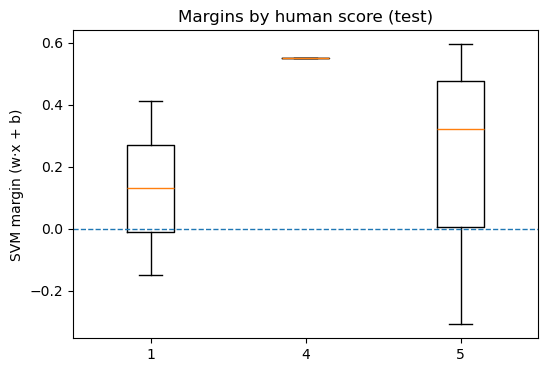

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
order = [1,2,3,4,5]
data = [margins_test[scores_test==k] for k in order]
plt.boxplot([d for d in data if len(d)], labels=[k for k,d in zip(order,data) if len(d)])
plt.axhline(0.0, ls="--", lw=1)
plt.title("Margins by human score (test)")
plt.ylabel("SVM margin (w·x + b)")
plt.show()


In [50]:
# Conversations whose FINAL turn has score == 5
last_turn = (df_plot.sort_values(["group_id","turn_idx"])
                     .groupby("group_id").tail(1))
jb_gids = last_turn[last_turn["score"] == 5]["group_id"].tolist()
print(f"jailbreak groups (score=5): {len(jb_gids)}")


jailbreak groups (score=5): 43


In [51]:
import math, numpy as np, matplotlib.pyplot as plt
import matplotlib as mpl

# Nice global style (pure matplotlib)
mpl.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.22,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.frameon": False,
    "font.size": 10,
})

def plot_jb_trajectories_annotated(df, gids, tau_early=0.20, tau_block=0.40,
                                   ncols=3, width=3.8, height=2.8,
                                   save_dir=None):
    """
    df: df_plot
    gids: list of group_id to plot (final score == 5)
    """
    if not gids:
        print("[info] no jailbreak conversations (score=5) found.")
        return

    # Consistent y-limits across panels
    all_m = np.concatenate([df.loc[df["group_id"]==g, "margin"].to_numpy() for g in gids])
    pad   = max(all_m.max() - all_m.min(), 0.05)
    ylim  = (all_m.min() - 0.10*pad, all_m.max() + 0.15*pad)

    n = len(gids)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*width, nrows*height), squeeze=False, sharey=True)

    for k, gid in enumerate(gids):
        r, c = divmod(k, ncols)
        ax = axes[r, c]

        g = (df[df["group_id"]==gid]
             .sort_values("turn_idx")
             .reset_index(drop=True))
        x = g["turn_idx"].to_numpy()
        y = g["margin"].to_numpy()
        s = g["score"].to_numpy()  # 1/2/4/5 per turn

        # Shaded risk zones
        ax.axhspan(tau_early, ylim[1], color="#ff7f0e", alpha=0.08, label=f"unsafe ≥ {tau_early:.2f}")
        ax.axhspan(tau_block, ylim[1], color="#d62728", alpha=0.10, label=f"block ≥ {tau_block:.2f}")

        # Line + markers
        ax.plot(x, y, lw=2.2, marker="o", markersize=5)

        # Annotations on every point: margin + score
        for xi, yi, si in zip(x, y, s):
            ax.annotate(f"{yi:+.2f}\n(s={si})",
                        (xi, yi),
                        textcoords="offset points",
                        xytext=(0, 8),
                        ha="center", va="bottom",
                        fontsize=9)

        # Reference lines
        ax.axhline(0.0,      ls="--", lw=1, color="k", alpha=0.6, label="τ=0")
        ax.axhline(tau_early, ls="--", lw=1, alpha=0.6)
        ax.axhline(tau_block, ls="--", lw=1, alpha=0.6)

        # Cosmetic
        ax.set_ylim(*ylim)
        ax.set_xticks(np.arange(x.min(), x.max()+1, 1))
        ax.set_xlabel("turn index")
        ax.set_ylabel("SVM margin (w·x + b)") if c==0 else None

        # Title shows start/end margins
        ax.set_title(f"{gid[:10]}…  |  start {y[0]:+.2f} → end {y[-1]:+.2f}  (final score=5)")

        # Optional: save per-convo PNGs
        if save_dir is not None:
            fig_i, ax_i = plt.subplots(figsize=(6, 3))
            # repeat single panel content (quick export)
            ax_i.axhspan(tau_early, ylim[1], color="#ff7f0e", alpha=0.08)
            ax_i.axhspan(tau_block, ylim[1], color="#d62728", alpha=0.10)
            ax_i.plot(x, y, lw=2.2, marker="o", markersize=5)
            for xi, yi, si in zip(x, y, s):
                ax_i.annotate(f"{yi:+.2f}\n(s={si})", (xi, yi),
                              textcoords="offset points", xytext=(0, 8),
                              ha="center", va="bottom", fontsize=9)
            ax_i.axhline(0.0, ls="--", lw=1, color="k", alpha=0.6)
            ax_i.axhline(tau_early, ls="--", lw=1, alpha=0.6)
            ax_i.axhline(tau_block, ls="--", lw=1, alpha=0.6)
            ax_i.set_ylim(*ylim)
            ax_i.set_xticks(np.arange(x.min(), x.max()+1, 1))
            ax_i.set_xlabel("turn index"); ax_i.set_ylabel("margin")
            ax_i.set_title(f"{gid[:10]}…  (final=5)")
            fig_i.tight_layout()
            out = (Path(save_dir) / f"traj_{gid[:12]}.png")
            fig_i.savefig(out, bbox_inches="tight"); plt.close(fig_i)

    # Turn off empties
    for k in range(n, nrows*ncols):
        r, c = divmod(k, ncols)
        axes[r, c].axis("off")

    # One legend for the figure (from first axes)
    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles[:1], labels[:1], loc="upper right")  # keep it minimal

    fig.suptitle("Jailbreak trajectories (final score = 5)\nEach point: margin + score", y=1.04, fontsize=14, fontweight="bold")
    fig.tight_layout()
    plt.show()

# Call it
plot_jb_trajectories_annotated(df_plot, jb_gids, tau_early=TAU_EARLY, tau_block=TAU_BLOCK, ncols=3)


NameError: name 'TAU_EARLY' is not defined